In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define the path to the _Output directory
input_directory = "/content/drive/MyDrive/PlantClass/_Output"

# Initialize the images array
images = []

# Iterate through each folder in the _Output directory
for folder_name in os.listdir(input_directory):
    folder_path = os.path.join(input_directory, folder_name)

    # Ensure it's a directory
    if os.path.isdir(folder_path):
        # List to hold images for this folder
        folder_images = []

        # Iterate through each file in the folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            # Check if the file is an image (we'll assume all files are images)
            if os.path.isfile(file_path):
                # Read the image in grayscale
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                # Add the image to the list if it's successfully read
                if image is not None:
                    folder_images.append({
                        "image_name": file,
                        "image": image
                    })

        # If the folder contains images, append the folder object to the images array
        if folder_images:
            images.append({
                "folder_name": folder_name,
                "images": folder_images
            })

# Output the result
# print(images)


# debugging
# image = cv2.imread('_Output/Mango_(P0)/0001_0003.JPG', cv2.IMREAD_GRAYSCALE)


In [4]:
def contrast_adjustment(image):
    # Step 1: Normalize the image to range 0-255
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    # Step 2: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5, 5))  # Clip limit and grid size can be tuned
    enhanced_image = clahe.apply(normalized_image)

    # # Step 3: Optional - Adjust global contrast using scaling
    alpha = 1.3 # Contrast control (>1 increases contrast, <1 decreases it)
    beta = 1   # Brightness control (positive increases brightness)
    contrast_adjusted_image = cv2.convertScaleAbs(enhanced_image, alpha=alpha, beta=beta)

    # DEBUG
    # cv2.imshow('Original Image', image)
    # cv2.imshow('Normalized Image', normalized_image)
    # cv2.imshow('CLAHE Enhanced Image', enhanced_image)
    # cv2.imshow('Final Contrast Adjusted Image', contrast_adjusted_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return contrast_adjusted_image


In [5]:
def noise_reduction(image):
    modified_image = cv2.medianBlur(image, 7)

    # DEBUG
    # cv2.imshow('Blurred', modified_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return modified_image


In [6]:
# import cv2
# import numpy as np

def segmentation(image):
    # Step 1: Edge detection
    edges = cv2.Canny(image, 50, 120)

    # Step 2: Connect fragmented edges using dilation and closing
    kernel = np.ones((5, 5), np.uint8)  # Increase kernel size for better connection
    dilated_edges = cv2.dilate(edges, kernel, iterations=3)  # Increase dilation iterations
    closed_edges = cv2.morphologyEx(dilated_edges, cv2.MORPH_CLOSE, kernel, iterations=3)  # More closing iterations

    # Step 3: Detect contours from connected edges
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 4: Create a mask for the connected regions
    mask = np.zeros_like(image, dtype=np.uint8)
    for contour in contours:
        # Optional: Filter small contours
        if cv2.contourArea(contour) > 500:  # Adjust minimum area as needed
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Step 5: Segment the inner object using the mask
    _, binary_image = cv2.threshold(image, 140, 255, cv2.THRESH_BINARY)
    segmented = cv2.bitwise_and(binary_image, binary_image, mask=mask)

    # DEBUG
    # cv2.imshow('Original Image', image)
    # cv2.imshow('Edges', edges)
    # # cv2.imshow('Dilated and Closed Edges', closed_edges)
    # cv2.imshow('Connected Regions Mask', mask)
    # cv2.imshow('Segmented Inner Object', segmented)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return segmented


In [7]:
def improvement(image):
    # Create a circular kernel
    kernel_size = 3  # Adjust the size as needed
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Apply morphological opening
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=4)

    # Step 1: Find contours
    contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 2: Create a mask to filter regions based on position
    mask = np.zeros_like(image)
    height, width = image.shape
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filter contours based on position (e.g., ignore regions in the top 30% of the image)
        if y > height * 0.1 and cv2.contourArea(contour) > 1000:  # Adjust area threshold
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Step 3: Apply the mask to keep only the filtered regions
    cleaned_image = cv2.bitwise_and(image, mask)

    return cleaned_image


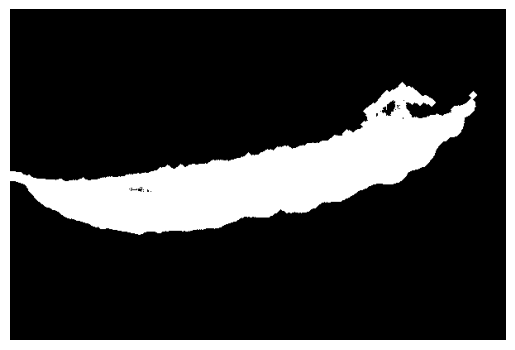

In [8]:
img = cv2.imread('/content/drive/MyDrive/PlantClass/_Output/Mango_(P0)/0001_0003.JPG', cv2.IMREAD_GRAYSCALE)

img = noise_reduction(img)
img = contrast_adjustment(img)
img = segmentation(img)
img = improvement(img)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [9]:
# Assuming images is the list of folder objects
truth_directory = "/content/drive/MyDrive/PlantClass/_Ground_Truth/_GroundTruth"  # Path to the ground truth images
output_directory = "segmented_output"
jaccard_scores = []  # List to store Jaccard index for each image

for folder_obj in images:
    folder_name = folder_obj['folder_name']
    folder_images = folder_obj['images']

    # Create a folder in "segmented_output" if it doesn't exist
    output_folder_path = os.path.join(output_directory, folder_name)
    os.makedirs(output_folder_path, exist_ok=True)

    # Iterate through each image in the folder
    for image_obj in folder_images:
        image_name = image_obj['image_name']
        image = image_obj['image']

        # Apply all image processing functions in sequence
        image = noise_reduction(image)
        image = contrast_adjustment(image)
        image = segmentation(image)
        image = improvement(image)

        # Save the processed image in the corresponding folder in "segmented_output"
        output_image_path = os.path.join(output_folder_path, image_name)
        cv2.imwrite(output_image_path, image)

        # Load the corresponding ground truth image
        ground_truth_path = os.path.join(truth_directory, folder_name, image_name)
        ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

        # Ensure ground truth image is binary (0 or 255)
        _, ground_truth_binary = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)

        # Ensure processed image is binary (0 or 255)
        _, processed_binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

        # Calculate Jaccard index
        intersection = np.sum((ground_truth_binary == 255) & (processed_binary == 255))  # Common positive pixels
        union = np.sum((ground_truth_binary == 255) | (processed_binary == 255))  # All positive pixels

        jaccard_index = intersection / float(union) if union != 0 else 0  # Avoid division by zero
        jaccard_scores.append(jaccard_index)

# Calculate average Jaccard index
average_jaccard_index = np.mean(jaccard_scores) if jaccard_scores else 0

# Print the average Jaccard index
print(f'Average Jaccard Index: {average_jaccard_index}')

# Debugging
# image = contrast_adjustment(image)
# image = noise_reduction(image)
# image = segmentation(image)
# image = improvement(image)
# cv2.imshow('after all', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()



Average Jaccard Index: 0.7473029531912573
